In [9]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
import importlib

from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_preproc_utils
importlib.reload(CEMBA_preproc_utils)
import CEMBA_clst_utils
import re

from scipy import sparse
import time
import anndata

# from scipy.io import mmread
# import fbpca

sys.path.insert(0, '../scripts')
import basic_utils

In [2]:
import matplotlib
matplotlib.__version__

'3.1.3'

# Task

- start from prepared files 

```metadata``` ```count matrix```

```anndata```
- get and store hvfeatures

# Settings

In [3]:
# !cp ./data/organized_scf/__init__datasets.py ./data/test_Jan6_Astro/

In [4]:
SRC_DIR = './datasets'
DST_DIR = './datasets'

sys.path.insert(0, SRC_DIR)
from __init__datasets import *


f_data_format = '{0}/{1}.h5ad'
f_hvftr_data_format = '{0}/{1}_hvfeatures.h5ad'

# f_meta_format = '{0}/{1}_metadata.tsv'
# f_data_format = '{0}/{1}_{2}raw.{3}'
# f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
# f_ftr_format = '{0}/{1}_features.{2}'

def get_size_in_GB(obj):
    """"""
    GB = 1024**3
    return sys.getsizeof(obj)/GB

In [5]:
mods_selected = [
    'snatac',
]

normalization_options = {
    'snatac': 'TPM',
}

In [6]:
# # # # gene name as index
# gene_annot_file = '/cndd2/fangming/projects/m3c/refs/gencode_v32_gene_annotation.bed' 
# gene_annot = pd.read_csv(gene_annot_file, sep="\t", names=['chr', 'start', 'end', 'gene_id', 'gene_name'])
# gene_annot_v2 = gene_annot.groupby('gene_name').first()
# print(gene_annot_v2.shape)
# gene_lengths_base = (gene_annot_v2['end'] - gene_annot_v2['start'])
# print(gene_lengths_base.head())
# get gene_lengths

# def clean_gene_ids(x):
#     """
#     """
#     start, end = re.search(".[0-9]+_", x).span()
#     return x[:start]+"_"+x[end:]

gtf = '/cndd/Public_Datasets/BICCN/BICCN2.0_whole_mouse_brain/references/refdata-gex-mm10-2020-A/genes/genes_biccn2.0.bed'
df_genes = pd.read_csv(gtf, sep="\t", header=None, 
                      )
# # df_genes['id'] = df_genes['id'].apply(clean_gene_ids)
df_genes = df_genes.set_index(3)
print(df_genes.shape)

gene_lengths_base = (df_genes[2] - df_genes[1])
print(gene_lengths_base.shape)
print(gene_lengths_base.head())

(32285, 15)
(32285,)
3
ENSMUSG00000051951    465597
ENSMUSG00000089699     46966
ENSMUSG00000102331     11595
ENSMUSG00000102343     80476
ENSMUSG00000025900    409684
dtype: int64


# highly variable features

snatac
snatac Reading in files 0.00013947486877441406
snatac Preproc and get highly variable genes 0.9154050350189209
Imputing gene lengths...
Removing low coverage genes...
Getting CPM..
Getting highly variable genes and logCPM...


ValueError: need at least one array to concatenate

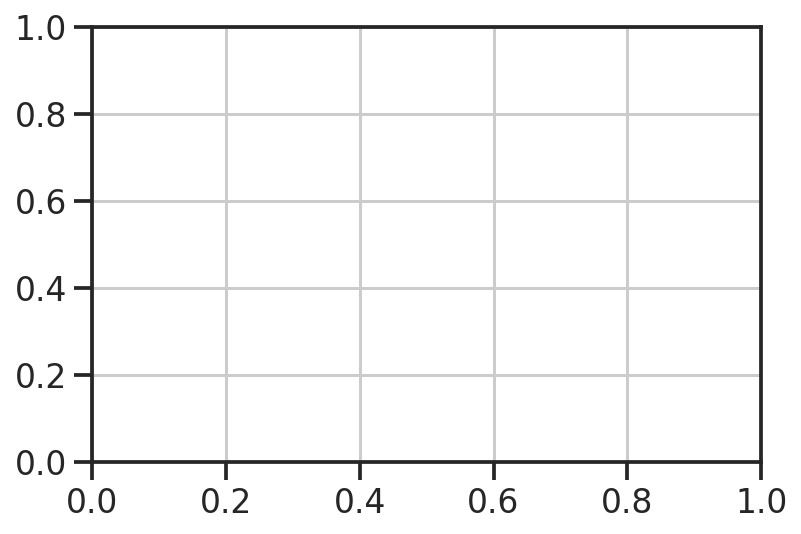

In [13]:
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    normalization_option = normalization_options[mod]
    
    # read metadata
#     f_meta = f_meta_format.format(SRC_DIR, mod) ##
#     meta = pd.read_csv(f_meta, sep="\t", index_col=0)
    
    # read data matrix
    if normalization_option == 'MC':
#         f_data_gene = f_data_format.format(SRC_DIR, mod, '', 'gene')
#         f_data_cell = f_data_format.format(SRC_DIR, mod, '', 'cell')
#         f_data_c = f_data_format.format(SRC_DIR, mod, 'CH_', 'npz')
#         f_data_mc = f_data_format.format(SRC_DIR, mod, 'mCH_', 'npz')
        
        f_data = f_data_format.format(SRC_DIR, mod)
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_raw = snmcseq_utils.load_gc_matrix_methylation(f_data_gene, f_data_cell, f_data_mc, f_data_c)
        print(gxc_raw.data['mc'].shape, gxc_raw.data['c'].shape)
        print(time.time()-ti)
        
        # output file
        f_hvftr_data_methylation = f_hvftr_format.format(DST_DIR, mod, 'tsv') 
        print(time.time()-ti)
        
        # check meta cells agree with gxc cells
        assert np.all(meta.index.values == gxc_raw.cell)
        # check genes are uniq 
        assert len(gxc_raw.gene) == len(np.unique(gxc_raw.gene)) 
        
        # do
        gxc_hvftr = CEMBA_preproc_utils.preproc_methylation(
                                                            gxc_raw,
                                                            meta,
                                                            global_value_col=settings[mod].global_mean, 
                                                            base_call_cutoff=20, 
                                                            sufficient_coverage_fraction=0.95,
                                                            hv_percentile=30,
                                                            n_qcut=10,
                                                            )
        # save
        print(mod, "Saving to files {}".format(time.time()-ti))
        gxc_hvftr.to_csv(f_hvftr_data_methylation, sep="\t", header=True, index=True, na_rep='NA')
        
        
        
    else:
        f_data = f_data_format.format(SRC_DIR, mod,) 
#         f_data_gene = f_data_format.format(SRC_DIR, mod, '', 'gene') 
#         f_data_cell = f_data_format.format(SRC_DIR, mod, '', 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        h5ad_mat = anndata.read_h5ad(f_data)
        
#         gxc_raw = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
#         print(gxc_raw.data.shape)
        
        # output files
        f_hvftr_data = f_hvftr_data_format.format(DST_DIR, mod) 
        
        meta, gxc_raw = basic_utils.h5ad_to_scf_rna_format(h5ad_mat)
        
#         # check meta cells agree with gxc cells
#         assert np.all(meta.index.values == gxc_raw.cell)
#         # check genes are uniq 
#         assert len(gxc_raw.gene) == len(np.unique(gxc_raw.gene)) 
    
        # get hvftrs
        print(mod, "Preproc and get highly variable genes {}".format(time.time()-ti))
        if normalization_option == 'CPM':
            gxc_hvftr = CEMBA_preproc_utils.preproc_rna_cpm_based(
                                             gxc_raw, 
                                             sufficient_cell_coverage=0.01, 
                                             hv_percentile=30, hv_ncut=10)
            # save
            print(mod, "Saving to files {}".format(time.time()-ti))
#             snmcseq_utils.save_gc_matrix(gxc_hvftr, f_hvftr_gene, f_hvftr_cell, f_hvftr_data)

        elif normalization_option == 'TPM':
            gene_lengths = gene_lengths_base.reindex(gxc_raw.gene)
            gxc_hvftr = CEMBA_preproc_utils.preproc_rna_tpm_based(
                                             gxc_raw, gene_lengths, impute_gene_lengths=True, 
                                             sufficient_cell_coverage=0.01, 
                                             hv_percentile=30, hv_ncut=10)
            # save
            print(mod, "Saving to files {}".format(time.time()-ti))
#             snmcseq_utils.save_gc_matrix(gxc_hvftr, f_hvftr_gene, f_hvftr_cell, f_hvftr_data)
    
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

In [17]:
h5ad_mat.var

,chr,start,end,ensid,gene,strand,type
index,,,,,,,
0,chr1,3073253,3074322,ENSMUSG00000102693.1,4933401J01Rik,+,TEC
1,chr1,3102016,3102125,ENSMUSG00000064842.1,Gm26206,+,snRNA
2,chr1,3205901,3671498,ENSMUSG00000051951.5,Xkr4,-,protein_coding
3,chr1,3252757,3253236,ENSMUSG00000102851.1,Gm18956,+,processed_pseudogene
4,chr1,3365731,3368549,ENSMUSG00000103377.1,Gm37180,-,TEC
...,...,...,...,...,...,...,...
53374,chrM,13552,14070,ENSMUSG00000064368.1,mt-Nd6,-,protein_coding
53375,chrM,14071,14139,ENSMUSG00000064369.1,mt-Te,-,Mt_tRNA
53376,chrM,14145,15288,ENSMUSG00000064370.1,mt-Cytb,+,protein_coding


## Check highly-variable genes

In [ ]:
for mod in mods_selected:
    print(mod)
    if settings[mod].mod_category == 'mc':
        f_hvftr_data = f_hvftr_format.format(SRC_DIR, mod, 'tsv') 
        gxc_hvftr = pd.read_csv(f_hvftr_data, sep="\t", index_col=0)
        print(gxc_hvftr.index.values)
        print(gxc_hvftr.columns.values)
        print(gxc_hvftr.shape)
        has_nan = np.isnan(gxc_hvftr.values).any()
        print("Contains NaN? {}".format(has_nan))
        
        continue
        
    f_hvftr_data = f_hvftr_format.format(SRC_DIR, mod, 'npz') 
    f_hvftr_gene = f_hvftr_format.format(SRC_DIR, mod, 'gene') 
    f_hvftr_cell = f_hvftr_format.format(SRC_DIR, mod, 'cell') 
    gxc_hvftr = snmcseq_utils.load_gc_matrix(f_hvftr_gene, f_hvftr_cell, f_hvftr_data)
    print(gxc_hvftr.gene)
    print(gxc_hvftr.cell)
    print(len(gxc_hvftr.gene), len(gxc_hvftr.cell), gxc_hvftr.data.shape)
    has_nan = np.isnan(gxc_hvftr.data.data).any()
    print("Contains NaN? {}".format(has_nan))
#     break